## Arboles de Decisión - Clasificación y Predicción ##

Los arboles de decisión son representaciones gráficas de posibles soluciones a una decisión basadas en ciertas condiciones.

Pueden realizar tareas de clasificación o regresión

In [1]:
# Importamos las librerias necesarioas y algunos script
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont



** Analisis Exploratorio de la Data** 

La predición se realizara para saber que Artista llegara a tener un exito en Billboard

In [2]:
#carga de Datos
DataArtistas = pd.read_csv(r"DataArtistas.csv")
DataArtistas.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


In [3]:
DataArtistas.shape

(635, 11)

In [4]:
## Verifiquemos la distribución del target a Predecir
DataArtistas.groupby('top').size()

top
0    494
1    141
dtype: int64

In [5]:
141/494*100


28.542510121457486

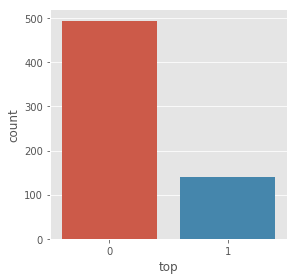

In [6]:
# Grafiquemos la distribución
sb.factorplot('top',data=DataArtistas,kind="count")

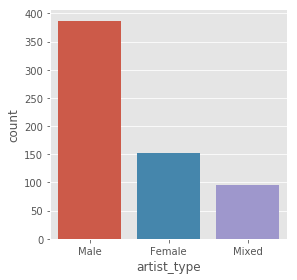

In [7]:
# Visualicemos los Artistas 
sb.factorplot('artist_type',data=DataArtistas,kind="count") 

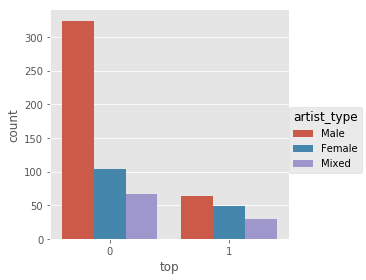

In [8]:
# Visualicemos los Artistas respecto al Target
sb.factorplot('top',data=DataArtistas,hue='artist_type',kind="count")

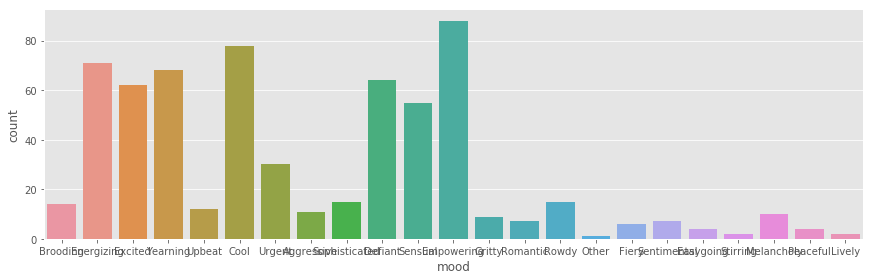

In [9]:
# Estado de animo que genera la canción 
sb.factorplot('mood',data=DataArtistas,kind="count", aspect=3)

In [10]:
#DataArtistas

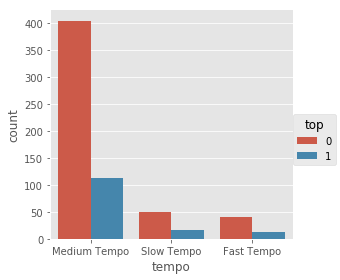

In [11]:
# Analisis de acuerdo al tiempo de la Canción
sb.factorplot('tempo',data=DataArtistas,hue='top',kind="count")

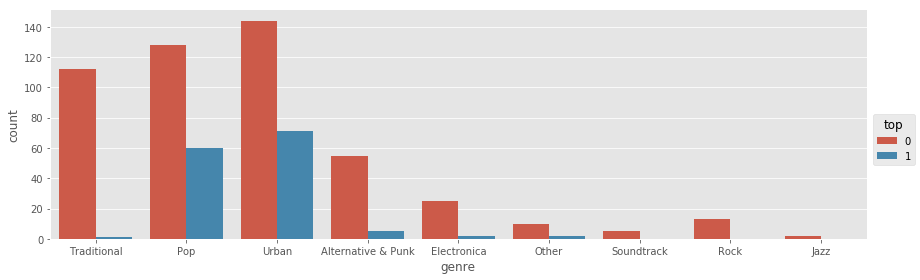

In [12]:
# Segun el Genero de la canción
sb.factorplot('genre',data=DataArtistas, hue='top', kind="count", aspect=3)

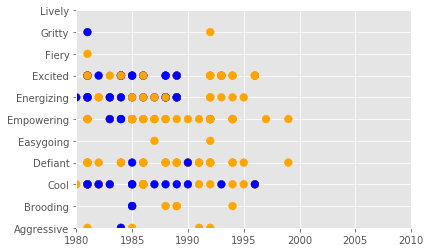

In [13]:
# Busquemos alguna relación entre 2 variables (Año y Duración)
colores=['orange','blue']
tamanios=[60,40]

f1 = DataArtistas['anioNacimiento'].values
f2 = DataArtistas['mood'].values #mood -- durationSeg

asignar=[]
for index, row in DataArtistas.iterrows():    
    asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=60)
plt.axis([1980,2010,0,10]) #10
plt.show()

Esto nos Sirve para encontrar algun patron entre las variables

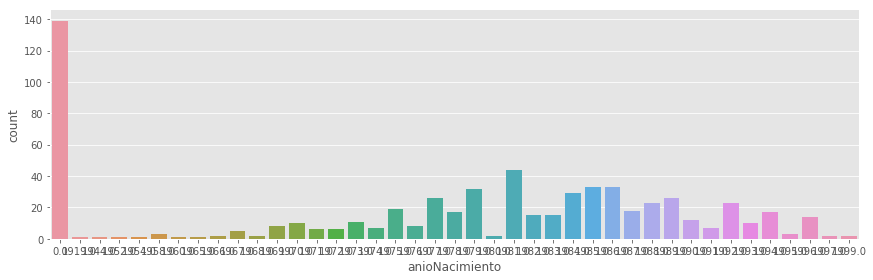

In [14]:
# Verificando el año de Nacimiento de los Artistas
sb.factorplot('anioNacimiento',data=DataArtistas,kind="count", aspect=3)

In [15]:
# validadmos Cuantos Artistas no tienen fecha de nacimiento
nacimientosPorAnio = DataArtistas['anioNacimiento']
len(nacimientosPorAnio[nacimientosPorAnio<=0])


139

In [16]:
def edad_fix(anio):
    if anio==0:
        return None
    return anio

DataArtistas['anioNacimiento']=DataArtistas.apply(lambda x: edad_fix(x['anioNacimiento']), axis=1);

In [17]:
def calcula_edad(anio,cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio==0.0:
        return None
    return int(momento) - anio

DataArtistas['edad_en_billboard']=DataArtistas.apply(lambda x: calcula_edad(x['anioNacimiento'],x['chart_date']), axis=1);

** Calculamos el promedio de edad y asignamos a los registros Nulos **

In [18]:
age_avg = DataArtistas['edad_en_billboard'].mean()
age_std = DataArtistas['edad_en_billboard'].std()
age_null_count = DataArtistas['edad_en_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

conValoresNulos = np.isnan(DataArtistas['edad_en_billboard'])

DataArtistas.loc[np.isnan(DataArtistas['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
DataArtistas['edad_en_billboard'] = DataArtistas['edad_en_billboard'].astype(int)

In [19]:
print("Edad Promedio: " + str(age_avg))
print("Desvió Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10282258064516
Desvió Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 38


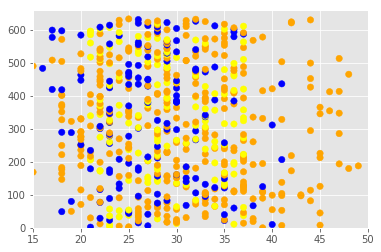

In [20]:
f1 = DataArtistas['edad_en_billboard'].values
f2 = DataArtistas.index

colores = ['orange','blue','yellow']

asignar=[]
for index, row in DataArtistas.iterrows():    
    if (conValoresNulos[index]):
        asignar.append(colores[2]) # Amarillo
    else:
        asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=40)
plt.axis([15,50,0,660])
plt.show()

## Mapeando los atributos ##

Para poder convertirlos en categorias

In [21]:
# Mood
DataArtistas.groupby('mood').size()

mood
Aggressive       11
Brooding         14
Cool             78
Defiant          64
Easygoing         4
Empowering       88
Energizing       71
Excited          62
Fiery             6
Gritty            9
Lively            2
Melancholy       10
Other             1
Peaceful          4
Romantic          7
Rowdy            15
Sensual          55
Sentimental       7
Sophisticated    15
Stirring          2
Upbeat           12
Urgent           30
Yearning         68
dtype: int64

In [22]:
# Mood Mapping 
DataArtistas['moodEncoded'] = DataArtistas['mood'].map( {'Energizing': 6, 
                                        'Empowering': 6,
                                        'Cool': 5, 
                                        'Yearning': 4, # anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3, 
                                        'Sensual': 2, 
                                        'Gritty': 3, #coraje 
                                        'Sophisticated': 4,
                                        'Aggressive': 4, # provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3, 
                                        'Rowdy': 4, #ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1, # sencillo
                                        'Melancholy': 4, 
                                        'Romantic': 2, 
                                        'Peaceful': 1, 
                                        'Brooding': 4, # melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,'':0} ).astype(int)

In [23]:
# Detalle tempo
DataArtistas.groupby('tempo').size()

tempo
Fast Tempo       53
Medium Tempo    517
Slow Tempo       65
dtype: int64

In [24]:
# Tempo Mapping 
DataArtistas['tempoEncoded'] = DataArtistas['tempo'].map( {'Fast Tempo': 0, 'Medium Tempo': 2, 'Slow Tempo': 1, '': 0} ).astype(int)

In [25]:
# Detalle genre
DataArtistas.groupby('genre').size()

genre
Alternative & Punk     60
Electronica            27
Jazz                    2
Other                  12
Pop                   188
Rock                   13
Soundtrack              5
Traditional           113
Urban                 215
dtype: int64

In [26]:
# Genre Mapping 
DataArtistas['genreEncoded'] = DataArtistas['genre'].map( {'Urban': 4, 
                                          'Pop': 3, 
                                          'Traditional': 2, 
                                          'Alternative & Punk': 1,
                                         'Electronica': 1, 
                                          'Rock': 1, 
                                          'Soundtrack': 0, 
                                          'Jazz': 0,
                                          'Other':0,'':0} 
                                       ).astype(int)

In [27]:
#DataArtistas

In [28]:
# Detalle genre
DataArtistas.groupby('artist_type').size()

artist_type
Female    153
Male      387
Mixed      95
dtype: int64

In [29]:
# artist_type Mapping 
DataArtistas['artist_typeEncoded'] = DataArtistas['artist_type'].map( {'Female': 2, 'Male': 3, 'Mixed': 1, '': 0} ).astype(int)

In [30]:
# Detalle edad_en_billboard
DataArtistas.groupby('edad_en_billboard').size()

edad_en_billboard
15     2
16     1
17     4
18    18
19     4
20    21
21    18
22    37
23    35
24    21
25    33
26    27
27    32
28    41
29    48
30    34
31    20
32    27
33    35
34    18
35    34
36    24
37    32
38     8
39     9
40     5
41     9
42     4
43     2
44     7
45     7
46     2
47     5
48     2
49     1
54     1
56     3
61     1
62     1
70     1
95     1
dtype: int64

In [31]:
# Mapping edad en la que llegaron al billboard
DataArtistas.loc[ DataArtistas['edad_en_billboard'] <= 21, 'edadEncoded'] = 0
DataArtistas.loc[(DataArtistas['edad_en_billboard'] > 21) & (DataArtistas['edad_en_billboard'] <= 26), 'edadEncoded'] = 1
DataArtistas.loc[(DataArtistas['edad_en_billboard'] > 26) & (DataArtistas['edad_en_billboard'] <= 30), 'edadEncoded'] = 2
DataArtistas.loc[(DataArtistas['edad_en_billboard'] > 30) & (DataArtistas['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
DataArtistas.loc[ DataArtistas['edad_en_billboard'] > 40, 'edadEncoded'] = 4

In [32]:
# Detalle edad_en_billboard
DataArtistas.groupby('edad_en_billboard').size()

edad_en_billboard
15     2
16     1
17     4
18    18
19     4
20    21
21    18
22    37
23    35
24    21
25    33
26    27
27    32
28    41
29    48
30    34
31    20
32    27
33    35
34    18
35    34
36    24
37    32
38     8
39     9
40     5
41     9
42     4
43     2
44     7
45     7
46     2
47     5
48     2
49     1
54     1
56     3
61     1
62     1
70     1
95     1
dtype: int64

In [33]:
# Mapping Song Duration
DataArtistas.loc[ DataArtistas['durationSeg'] <= 150, 'durationEncoded'] = 0
DataArtistas.loc[(DataArtistas['durationSeg'] > 150) & (DataArtistas['durationSeg'] <= 180), 'durationEncoded'] = 1
DataArtistas.loc[(DataArtistas['durationSeg'] > 180) & (DataArtistas['durationSeg'] <= 210), 'durationEncoded'] = 2
DataArtistas.loc[(DataArtistas['durationSeg'] > 210) & (DataArtistas['durationSeg'] <= 240), 'durationEncoded'] = 3
DataArtistas.loc[(DataArtistas['durationSeg'] > 240) & (DataArtistas['durationSeg'] <= 270), 'durationEncoded'] = 4
DataArtistas.loc[(DataArtistas['durationSeg'] > 270) & (DataArtistas['durationSeg'] <= 300), 'durationEncoded'] = 5
DataArtistas.loc[ DataArtistas['durationSeg'] > 300, 'durationEncoded'] = 6

In [34]:
DataArtistas

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39,4,2,2,3,3.0,2.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25,6,2,3,2,1.0,6.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21,5,2,4,1,0.0,3.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25,4,2,1,3,1.0,2.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN,23,4,2,2,2,1.0,3.0
5,5,Where Is At (Yep Yep),DUSTIN LYNCH,Upbeat,Medium Tempo,Traditional,Male,20140531,219.0,0,1990.0,24,5,2,2,3,1.0,3.0
6,6,Single Ladies (Put A Ring On It),BEYONCE,Cool,Slow Tempo,Urban,Female,20081213,43.0,1,1981.0,27,5,1,4,2,2.0,0.0
7,7,Me And My Broken Heart,RIXTON,Urgent,Fast Tempo,Pop,Male,20140412,557.0,0,1973.0,41,3,0,3,3,4.0,6.0
8,8,I Luh Ya Papi,JENNIFER LOPEZ featuring FRENCH MONTANA,Aggressive,Medium Tempo,Urban,Female,20140329,182.0,0,1969.0,45,4,2,4,2,4.0,2.0
9,9,Chocolate,THE 1975,Yearning,Medium Tempo,Alternative & Punk,Male,20140208,347.0,0,NaN,23,4,2,1,3,1.0,6.0


## Generando la Nueva Data Para el Modelo ##

In [35]:
# Listar las columnas que no se utilizaran
drop_elements = ['id','title','artist','mood','tempo','genre','artist_type','chart_date','anioNacimiento','durationSeg','edad_en_billboard']

In [36]:
# Nuevos Datos Codificados
newDataArtistas = DataArtistas.drop(drop_elements, axis = 1)

In [37]:
newDataArtistas.head()

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
0,0,4,2,2,3,3.0,2.0
1,0,6,2,3,2,1.0,6.0
2,1,5,2,4,1,0.0,3.0
3,0,4,2,1,3,1.0,2.0
4,0,4,2,2,2,1.0,3.0


In [38]:
DataArtistas.describe()

,id,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
count,635.000000,6.350000e+02,635.000000,635.000000,496.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,317.000000,2.013036e+07,321.768504,0.222047,1982.570565,29.855118,4.344882,1.730709,2.755906,2.459843,2.026772,3.179528
std,183.452991,2.617996e+04,633.753787,0.415950,8.346478,7.805065,1.350003,0.603553,1.165463,0.740583,1.140414,1.775017
min,0.000000,2.004021e+07,0.000000,0.000000,1919.000000,15.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,158.500000,2.014010e+07,200.000000,0.000000,1978.000000,24.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000
50%,317.000000,2.014051e+07,232.000000,0.000000,1984.000000,29.000000,4.000000,2.000000,3.000000,3.000000,2.000000,3.000000
75%,475.500000,2.014101e+07,266.500000,0.000000,1988.000000,34.500000,5.500000,2.000000,4.000000,3.000000,3.000000,4.000000
max,634.000000,2.015031e+07,6840.000000,1.000000,1999.000000,95.000000,6.000000,2.000000,4.000000,3.000000,4.000000,6.000000


In [39]:
newDataArtistas.describe()

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,0.222047,4.344882,1.730709,2.755906,2.459843,2.026772,3.179528
std,0.415950,1.350003,0.603553,1.165463,0.740583,1.140414,1.775017
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000
50%,0.000000,4.000000,2.000000,3.000000,3.000000,2.000000,3.000000
75%,0.000000,5.500000,2.000000,4.000000,3.000000,3.000000,4.000000
max,1.000000,6.000000,2.000000,4.000000,3.000000,4.000000,6.000000


In [40]:
# Detalle de una sola variable
newDataArtistas[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
moodEncoded                    
0            0.000000     1   0
1            0.000000     8   0
2            0.274194    62  17
3            0.145631   103  15
4            0.136986   146  20
5            0.294872   156  46
6            0.270440   159  43

In [41]:
# verificando el Tipo de Artista
newDataArtistas[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                        mean count sum
artist_typeEncoded                    
1                   0.305263    95  29
2                   0.320261   153  49
3                   0.162791   387  63

In [42]:
# verificando segun el tiempo de duración
newDataArtistas[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                     mean count sum
durationEncoded                    
0.0              0.295775    71  21
1.0              0.333333    30  10
2.0              0.212963   108  23
3.0              0.202381   168  34
4.0              0.232143   112  26
5.0              0.145455    55   8
6.0              0.208791    91  19

## Arbol de Decisión - Atributos (tunnig) ##

Utilizamos de la librería de sklearn **tree.DecisionTreeClasifier** 

**criterion** = entropy ó podría ser gini, pero utilizamos entradas categóricas

**min_samples_split** = 20 se refiere a la cantidad mínima de muestras que debe tener un nodo para poder subdividir.

**min_samples_leaf** = 5 cantidad mínima que puede tener una hoja final. 

**class_weight** = {1:3.5} IMPORTANTíSIMO: con esto compensamos los desbalances que hubiera.

In [43]:
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
max_attributes = len(list(newDataArtistas))
depth_range = range(1, max_attributes + 1)
accuracies = list()

In [44]:
print('', cv)
print('', max_attributes)

 KFold(n_splits=10, random_state=None, shuffle=False)
 7


In [45]:
#newDataArtistas.head()

In [46]:
# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:3.5})
    for train_fold, valid_fold in cv.split(newDataArtistas):
        f_train = newDataArtistas.loc[train_fold] 
        f_valid = newDataArtistas.loc[valid_fold] 

        model = tree_model.fit(X = f_train.drop(['top'], axis=1),  y = f_train["top"]) 
        valid_acc = model.score(X = f_valid.drop(['top'], axis=1), y = f_valid["top"]) 
        # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

In [47]:
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

Max Depth  Average Accuracy
        1          0.556101
        2          0.556126
        3          0.564038
        4          0.644097
        5          0.607986
        6          0.626711
        7          0.626687


## Creamos el Arbol de Decisión ##

In [48]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
y_train = newDataArtistas['top']
x_train = newDataArtistas.drop(['top'], axis=1).values 

In [49]:
# Crear Arbol de decision con profundidad = 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=40,
                                            min_samples_leaf=5,
                                            max_depth = 7,
                                            class_weight={1:3.5})

In [50]:
# Utilizar en Modelo con las Data de Entrenamiento
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={1: 3.5}, criterion='entropy',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=40,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [51]:
# https://www.billboard.com/charts/hot-100

In [52]:
# Presición del arbol de Desición
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(acc_decision_tree)

69.76


## Validando los Nuevos Artistas - Billboard ##

In [53]:
#predecir artista CAMILA CABELLO featuring YOUNG THUG
# Cardi B, Bad Bunny & J Balvin
x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (1,5,4,4,1,0,6)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")


Prediccion: [1]
Probabilidad de Acierto: 86.21%


In [54]:
#predecir artista Imagine Dragons 
# con su canción Believer llego al puesto 42 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (0,5,3,1,4,2,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: 74.07%
